In [1]:
# 导入各种包
import pandas as pd
%pylab
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import re

sns.set()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("D:/anydata/data/pacifier.tsv", sep='\t') # 读取tsv格式数据
df.head()#显示前5行

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,40626522,R1A3ZUBR8TSAKY,B00793CZAE,572944212,"mary meyer wubbanub plush pacifier, lamb",Baby,5,0,0,N,Y,Love this!,Perfect match for the Gund Huggybuddy I bought...,8/31/2015
1,US,16290022,RLJNYBK4FGBYX,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,Love 💕,My little girl love this paci contraption!,8/31/2015
2,US,10216509,R26QCW75C4JDOK,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,Five Stars,My son loves this one and will only sleep if h...,8/31/2015
3,US,114040,R2E7N0TVLUHUDR,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,Five Stars,Perfect,8/31/2015
4,US,27971579,R1SO9VMCIGZX3U,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,Five Stars,Amazing addition to the nursery!,8/31/2015


In [3]:
df.info() # 查看数据缺省情况，很好，没有缺省值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18939 entries, 0 to 18938
Data columns (total 15 columns):
marketplace          18939 non-null object
customer_id          18939 non-null int64
review_id            18939 non-null object
product_id           18939 non-null object
product_parent       18939 non-null int64
product_title        18939 non-null object
product_category     18939 non-null object
star_rating          18939 non-null int64
helpful_votes        18939 non-null int64
total_votes          18939 non-null int64
vine                 18939 non-null object
verified_purchase    18939 non-null object
review_headline      18939 non-null object
review_body          18937 non-null object
review_date          18939 non-null object
dtypes: int64(5), object(10)
memory usage: 2.2+ MB


# 问题一
分析星级、评论以及帮助等级

In [4]:
'''
文本处理
1.将标题和主体合并得到评论（review）
2.去掉符号
3.分割得到词汇并转换成小写
4.去掉停词
'''
#停词表
stopwords_list = [line.rstrip() for line in open('D:/anydata/data/baidu_stopword.txt')]

def clean_text(text):
    try:
        text = BeautifulSoup(str(text), 'html.parser').get_text() # 去掉网页标签
    except:
        print(txt)
    else:
        pass
    
    text = re.sub(r'[^a-zA-Z]', ' ', text) # 利用正则表达式去掉标点
    words=text.lower().split() # 小写并且分割成单词
    
    words=[w for w in words if w not in stopwords_list] # 去掉停词
    return ' '.join(words) # 返回字符串

df["review"] = df.review_headline + " " + df.review_body# 清洗
df['review'] = df.review.apply(clean_text) # 清洗

## 星级
将星级分成三部分，积极，中立和消极，分别看出现的高频词汇和品牌

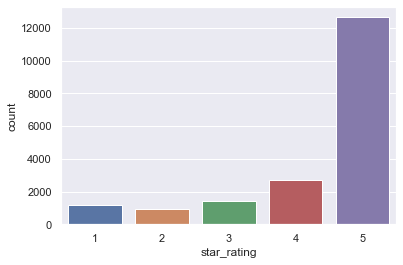

In [5]:
# 星级分布
sns.countplot(x=df["star_rating"], data = df)


In [6]:
#将星级分成几部分(1:好评, 0:中评, -1:差评)
df.loc[df['star_rating'] < 3, 'star_sentiment'] = -1
df.loc[df['star_rating'] == 3, 'star_sentiment'] = 0
df.loc[df['star_rating'] > 3, 'star_sentiment'] = 1

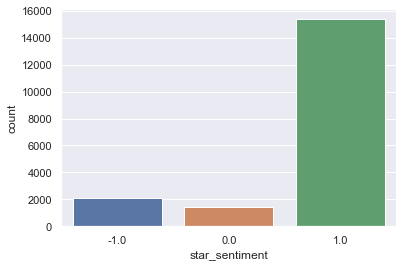

In [7]:
sns.countplot(x=df["star_sentiment"], data = df)
# 可以看出好评占多数

In [8]:
def getTxt(ss):
    '''ss是包含字符串的数组，返回一个字符串'''
    txt = ""
    for i in range(len(ss)):
        txt += ss[i]
    return txt

def countWord(txt, num=20):
    '''txt:一个长的字符串，返回前20个高频词汇'''
    txtArr = txt.split()
    counts = {}
    for word in txtArr:
        counts[word] = counts.get(word, 0) + 1

    countsList = list(counts.items())
    countsList.sort(key=lambda x:x[1], reverse=True)#按次数从大到小排序

    '''打印
    for i in range(20):
        word, count = countsList[i]
        print('{0:<10}{1:>5}'.format(word,count))
    '''
    return countsList[:num]

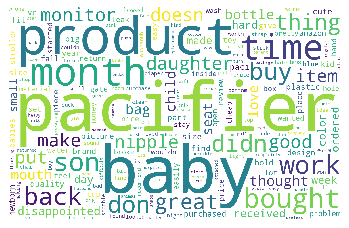

In [9]:
# 星级低的高频词汇
from wordcloud import WordCloud
txt = getTxt(df.loc[df['star_sentiment'] == -1, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)

plt.imshow(wordcloud)
plt.axis("off")
# 打印前20个词
star_negative_word = countWord(txt)

star_negative_title = df.loc[df['star_sentiment'] == -1, 'product_title'].value_counts()[:10]

In [10]:
pd.DataFrame(star_negative_word)

,0,1
0,baby,765
1,pacifier,503
2,product,421
3,pacifiers,315
4,son,288
5,time,284
6,bought,275
7,months,257
8,doesn,257
9,don,255


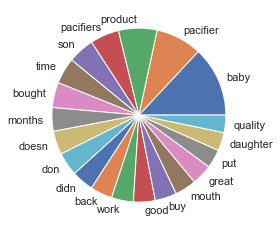

In [11]:
star_negative_word = np.array(star_negative_word)
plt.pie(x = star_negative_word[:, 1], labels = star_negative_word[:, 0])
plt.show()

In [12]:
pd.DataFrame(star_negative_title).index

Index(['philips avent bpa free soothie pacifier, 0-3 months, 2 pack, packaging may vary',
       'the original billy-bob teeth two front teeth pacifier',
       'wubbanub soft toy and pacifier', 'wubbanub infant pacifier - giraffe',
       'wubbanub brown monkey pacifier', 'razbaby keep-it-kleen pacifier',
       'fctry - baby pacifiers', 'nuby paci cradle pacifier box',
       'philips avent bpa free contemporary freeflow pacifier',
       'wubbanub lamb infant pacifier'],
      dtype='object')

In [13]:
pd.DataFrame(star_negative_title)

,product_title
"philips avent bpa free soothie pacifier, 0-3 months, 2 pack, packaging may vary",59
the original billy-bob teeth two front teeth pacifier,34
wubbanub soft toy and pacifier,33
wubbanub infant pacifier - giraffe,30
wubbanub brown monkey pacifier,25
razbaby keep-it-kleen pacifier,24
fctry - baby pacifiers,23
nuby paci cradle pacifier box,21
philips avent bpa free contemporary freeflow pacifier,21
wubbanub lamb infant pacifier,19


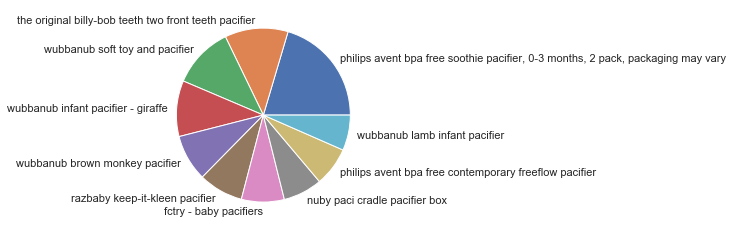

In [14]:
plt.pie(x = star_negative_title, labels = pd.DataFrame(star_negative_title).index)
plt.show()

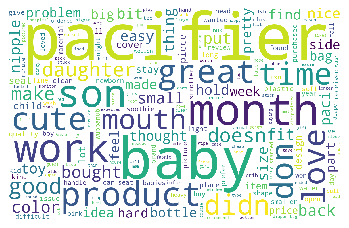

In [15]:
# 星级中等的
txt = getTxt(df.loc[df['star_sentiment'] == 0, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)

plt.imshow(wordcloud)
plt.axis("off")

# 取20个词
star_neutral_word = countWord(txt)
star_neutral_title = df.loc[df['star_sentiment'] == 0, 'product_title'].value_counts()[:10]

In [16]:
pd.DataFrame(star_neutral_word)

,0,1
0,baby,553
1,pacifier,462
2,pacifiers,250
3,great,227
4,son,224
5,doesn,214
6,good,194
7,mouth,191
8,product,189
9,don,189


In [17]:
pd.DataFrame(star_neutral_title)

,product_title
"philips avent bpa free soothie pacifier, 0-3 months, 2 pack, packaging may vary",44
wubbanub soft toy and pacifier,27
wubbanub brown monkey pacifier,23
wubbanub infant pacifier - giraffe,22
nuby paci cradle pacifier box,20
razbaby keep-it-kleen pacifier,20
"philips aventbpa free soothie pacifier, 3+ months, green, 2 count",17
philips avent bpa free night time pacifier,15
"philips avent translucent orthodontic infant pacifier, 0-6 months",15
fctry - baby pacifiers,15


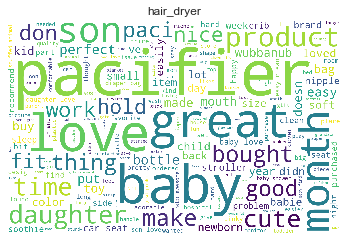

In [18]:
# 星级高的
txt = getTxt(df.loc[df['star_sentiment'] == 1, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.title("hair_dryer")
plt.imshow(wordcloud)
plt.axis("off")
# 前20个词
star_positive_word = countWord(txt)
star_positive_title = df.loc[df['star_sentiment'] == 1, 'product_title'].value_counts()[:10]

In [19]:
pd.DataFrame(star_positive_word)

,0,1
0,baby,5819
1,pacifier,4131
2,great,3919
3,love,3385
4,loves,2861
5,pacifiers,2633
6,easy,2389
7,son,2246
8,daughter,2157
9,product,1991


In [20]:
pd.DataFrame(star_positive_title)

,product_title
"philips avent bpa free soothie pacifier, 0-3 months, 2 pack, packaging may vary",706
wubbanub infant pacifier - giraffe,468
wubbanub brown monkey pacifier,419
wubbanub soft toy and pacifier,323
wubbanub brown puppy pacifier,233
philips avent bpa free contemporary freeflow pacifier,215
fctry - baby pacifiers,201
wubbanub lamb infant pacifier,196
wubbanub elephant pacifier,163
wubbanub tabby kitten pacifier,146


### 评论
将评论分成三部分，积极，中立和消极，分别看出现的高频词汇和品牌

In [21]:
# 用textblob分析文本极性
from textblob import TextBlob 

def get_sentiment(text): 
    ''' 
    调用TextBlob，返回-1 or  0 or  1
    '''
    analysis = TextBlob(text) 
    return np.sign(analysis.sentiment.polarity)

df['review_sentiment'] = df.review.apply(get_sentiment) # 调用函数

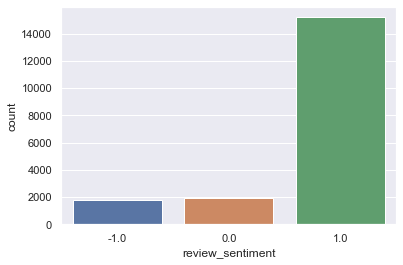

In [22]:
# 分布
sns.countplot(x=df["review_sentiment"], data = df)

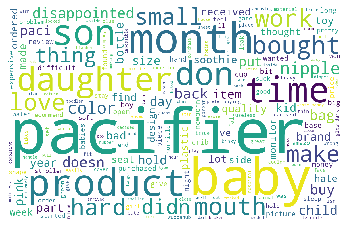

In [23]:
# 评论消极的
txt = getTxt(df.loc[df['review_sentiment'] == -1, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")

review_negative_word = countWord(txt)
review_negative_title = df.loc[df['review_sentiment'] == -1, 'product_title'].value_counts()[:10]

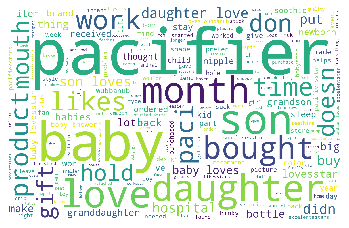

In [24]:
# 评论中立的
txt = getTxt(df.loc[df['review_sentiment'] == 0, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")

review_neutral_word = countWord(txt)
review_neutral_title = df.loc[df['review_sentiment'] == 0, 'product_title'].value_counts()[:10]

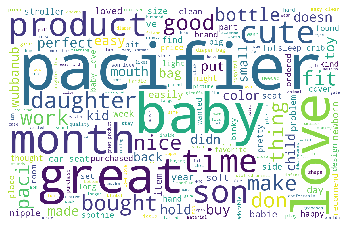

In [25]:
# 评论积极的
txt = getTxt(df.loc[df['review_sentiment'] == 1, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")

review_positive_word = countWord(txt)
review_positive_title = df.loc[df['review_sentiment'] == 1, 'product_title'].value_counts()[:10]

# 帮助等级
将帮助等级分成两部分，有用和没用，分别看出现的高频词汇和品牌

In [26]:
# 帮助等级分成有用和没用
df.loc[df['helpful_votes'] == 0, 'helpful_votes'] = 0
df.loc[df['helpful_votes'] > 0, 'helpful_votes'] = 1

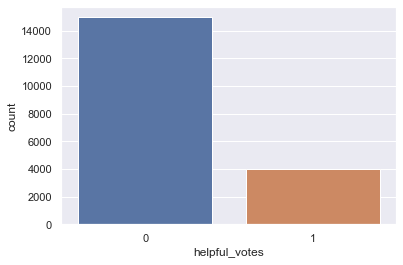

In [27]:
sns.countplot(x="helpful_votes", data = df)

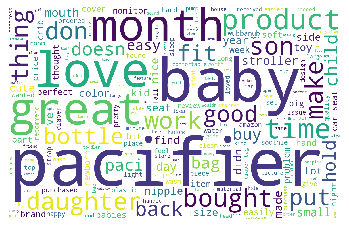

In [28]:
# 帮助有用的
txt = getTxt(df.loc[df['helpful_votes'] == 1, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")

helpful_word = countWord(txt)
helpful_title = df.loc[df['helpful_votes'] == 1, 'product_title'].value_counts()[:10]

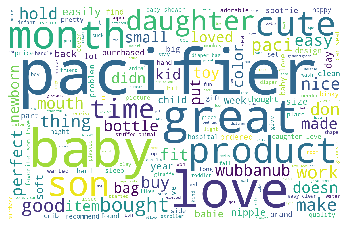

In [29]:
# 帮助没用的
txt = getTxt(df.loc[df['helpful_votes'] == 0, 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file("unhelpful.png") # 保存
# 打印前20个词
unhelpful_word = countWord(txt)
unhelpful_title = df.loc[df['helpful_votes'] == 0, 'product_title'].value_counts()[:10]

## 综合上面的来看
分析星级，评论，帮助等级得到了一些高频词汇和前十的品牌，整理如下：

# 第二问

### a)根据评级(rating)和评论评论(review)来确定最能提供信息的数据度量，使得阳光公司跟踪，一旦他们的三种产品在网上市场销售的话。

    最有信息含量的， 从两方面考虑，一个是该用户的满意程度， 另一个是该用户产生的影响
- 用户的满意程度
    根据(星级,评论)三个标准判断用户的满意程度.星级分1-5分,划分成-1, 0, 1; 评论分-1, 0, 1;如何描述用户满不满意呢?总的来说,星级越高,帮助等级越高,评分越高,用户越满意;可以给出一个满意程度的模型,比如简单的将前面两个的得分加起来(暂时没想到什么好方法, 具体可能要知道textblob的具体原理)
    
- 该用户产生的影响
由于帮助程度会产生马太效应，误差很大，因此使用提及属性比率


In [30]:
def make_data():
    data = []
    label = []
    for day in set(df.review_date.values):
        positive_star_num = sum(df.loc[df['review_date'] == day, 'star_sentiment'] >=0 )
        negative_star_num = sum(df.loc[df['review_date'] == day, 'star_sentiment'] < 0 )
        positive_review_num = sum(df.loc[df['review_date'] == day, 'review_sentiment'] >= 0 )
        negative_review_num = sum(df.loc[df['review_date'] == day, 'review_sentiment'] < 0 )
                              
        data.append([positive_star_num, negative_star_num, positive_review_num, negative_review_num])
        label.append(sum(df['review_date'] == day))
    return np.array(data), np.array(label)


In [31]:
data, label =  make_data()

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train , y_test = train_test_split(data, label)

In [33]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
lr.intercept_

1.7763568394002505e-15

In [35]:
lr.coef_ # ...怎么都是0.5, 

array([0.5, 0.5, 0.5, 0.5])

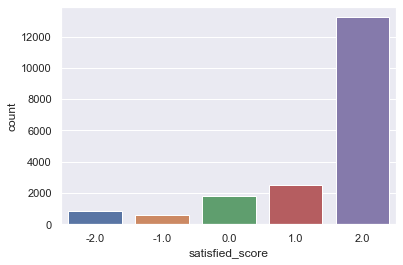

In [36]:
# 用户的满意程度
df['satisfied_score'] = df['star_sentiment'] + df['review_sentiment']

sns.countplot(x=df["satisfied_score"], data = df)

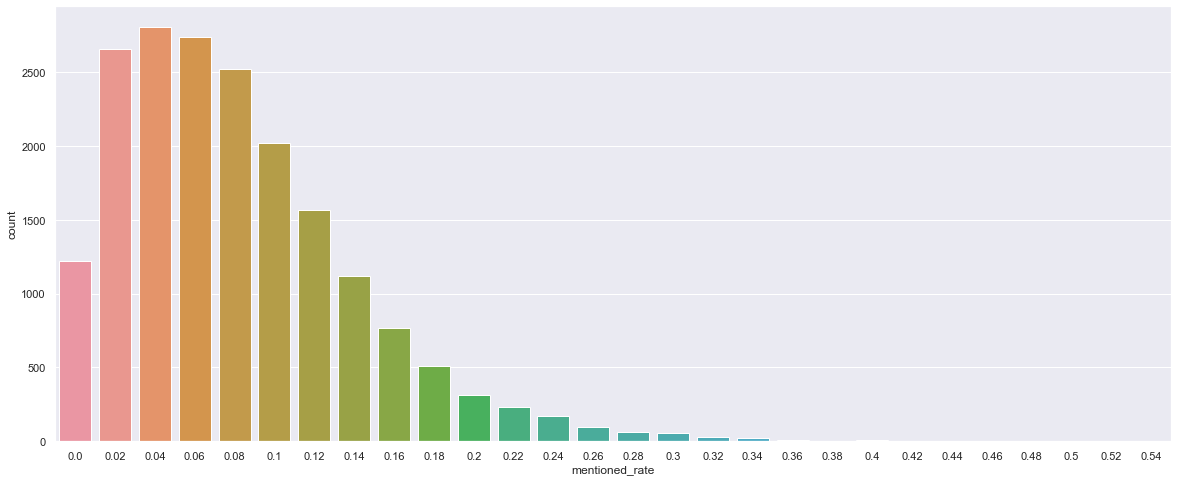

In [37]:
# 用户产生的影响
#获取所有评论中的高频词汇
txt = getTxt(df.review.values)
all_word = countWord(txt, num=50)

word_Arr = np.array(all_word)[:, 0]

def get_mentioned_rate(ss):
    word_set = set(ss.split())
    res = 0
    for word in word_set:
        if word in word_Arr:
            res += 1
    return res / len(word_Arr)
    
df["mentioned_rate"] = df.review.apply(get_mentioned_rate)

plt.figure(figsize=(20, 8))
sns.countplot(x="mentioned_rate", data=df)

In [38]:
df["review_len"] = df.review.apply(lambda ss: len(ss.split()))

### b)基于那些“能预测或暗示产品在市场上声誉增加或减少的”数据，来分析讨论“基于时间的度量方法(measures)和模式(patterns)”；
	从时间来看产品的声誉变化, 这里的数据有十多年,选择的时间段应该是月份或者年份.从第一问得到用户的满意程度,观察满意程度随时间变化即可.横坐标:时间(单位:年/月份);纵坐标:满意程度(单位:1)

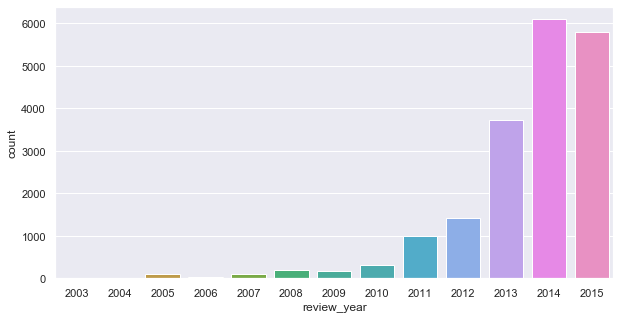

In [39]:
#按年份排列
df['review_year'] = pd.to_datetime(df.review_date).dt.strftime("%Y")
df.sort_values("review_year",inplace=True)
# 销量
plt.figure(figsize=(10,5))
sns.countplot(x="review_year", data=df)

<BarContainer object of 13 artists>

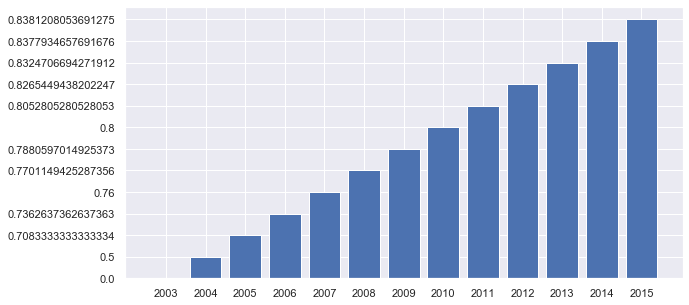

In [40]:
reputation_list = []
for year in set(df['review_year'].values):
    positive_number = np.sum(df.loc[df['review_year'] == year, 'satisfied_score'] > 0)
    rate = positive_number / sum(df['review_year'] == year)
    reputation_list.append([year, rate])
reputation_list = np.array(reputation_list)
reputation_list.sort(axis = 0) # 将年份排列

plt.figure(figsize=(10 ,5))
plt.bar(reputation_list[:,0], reputation_list[:,1])
# 可以看到声誉一直在增长

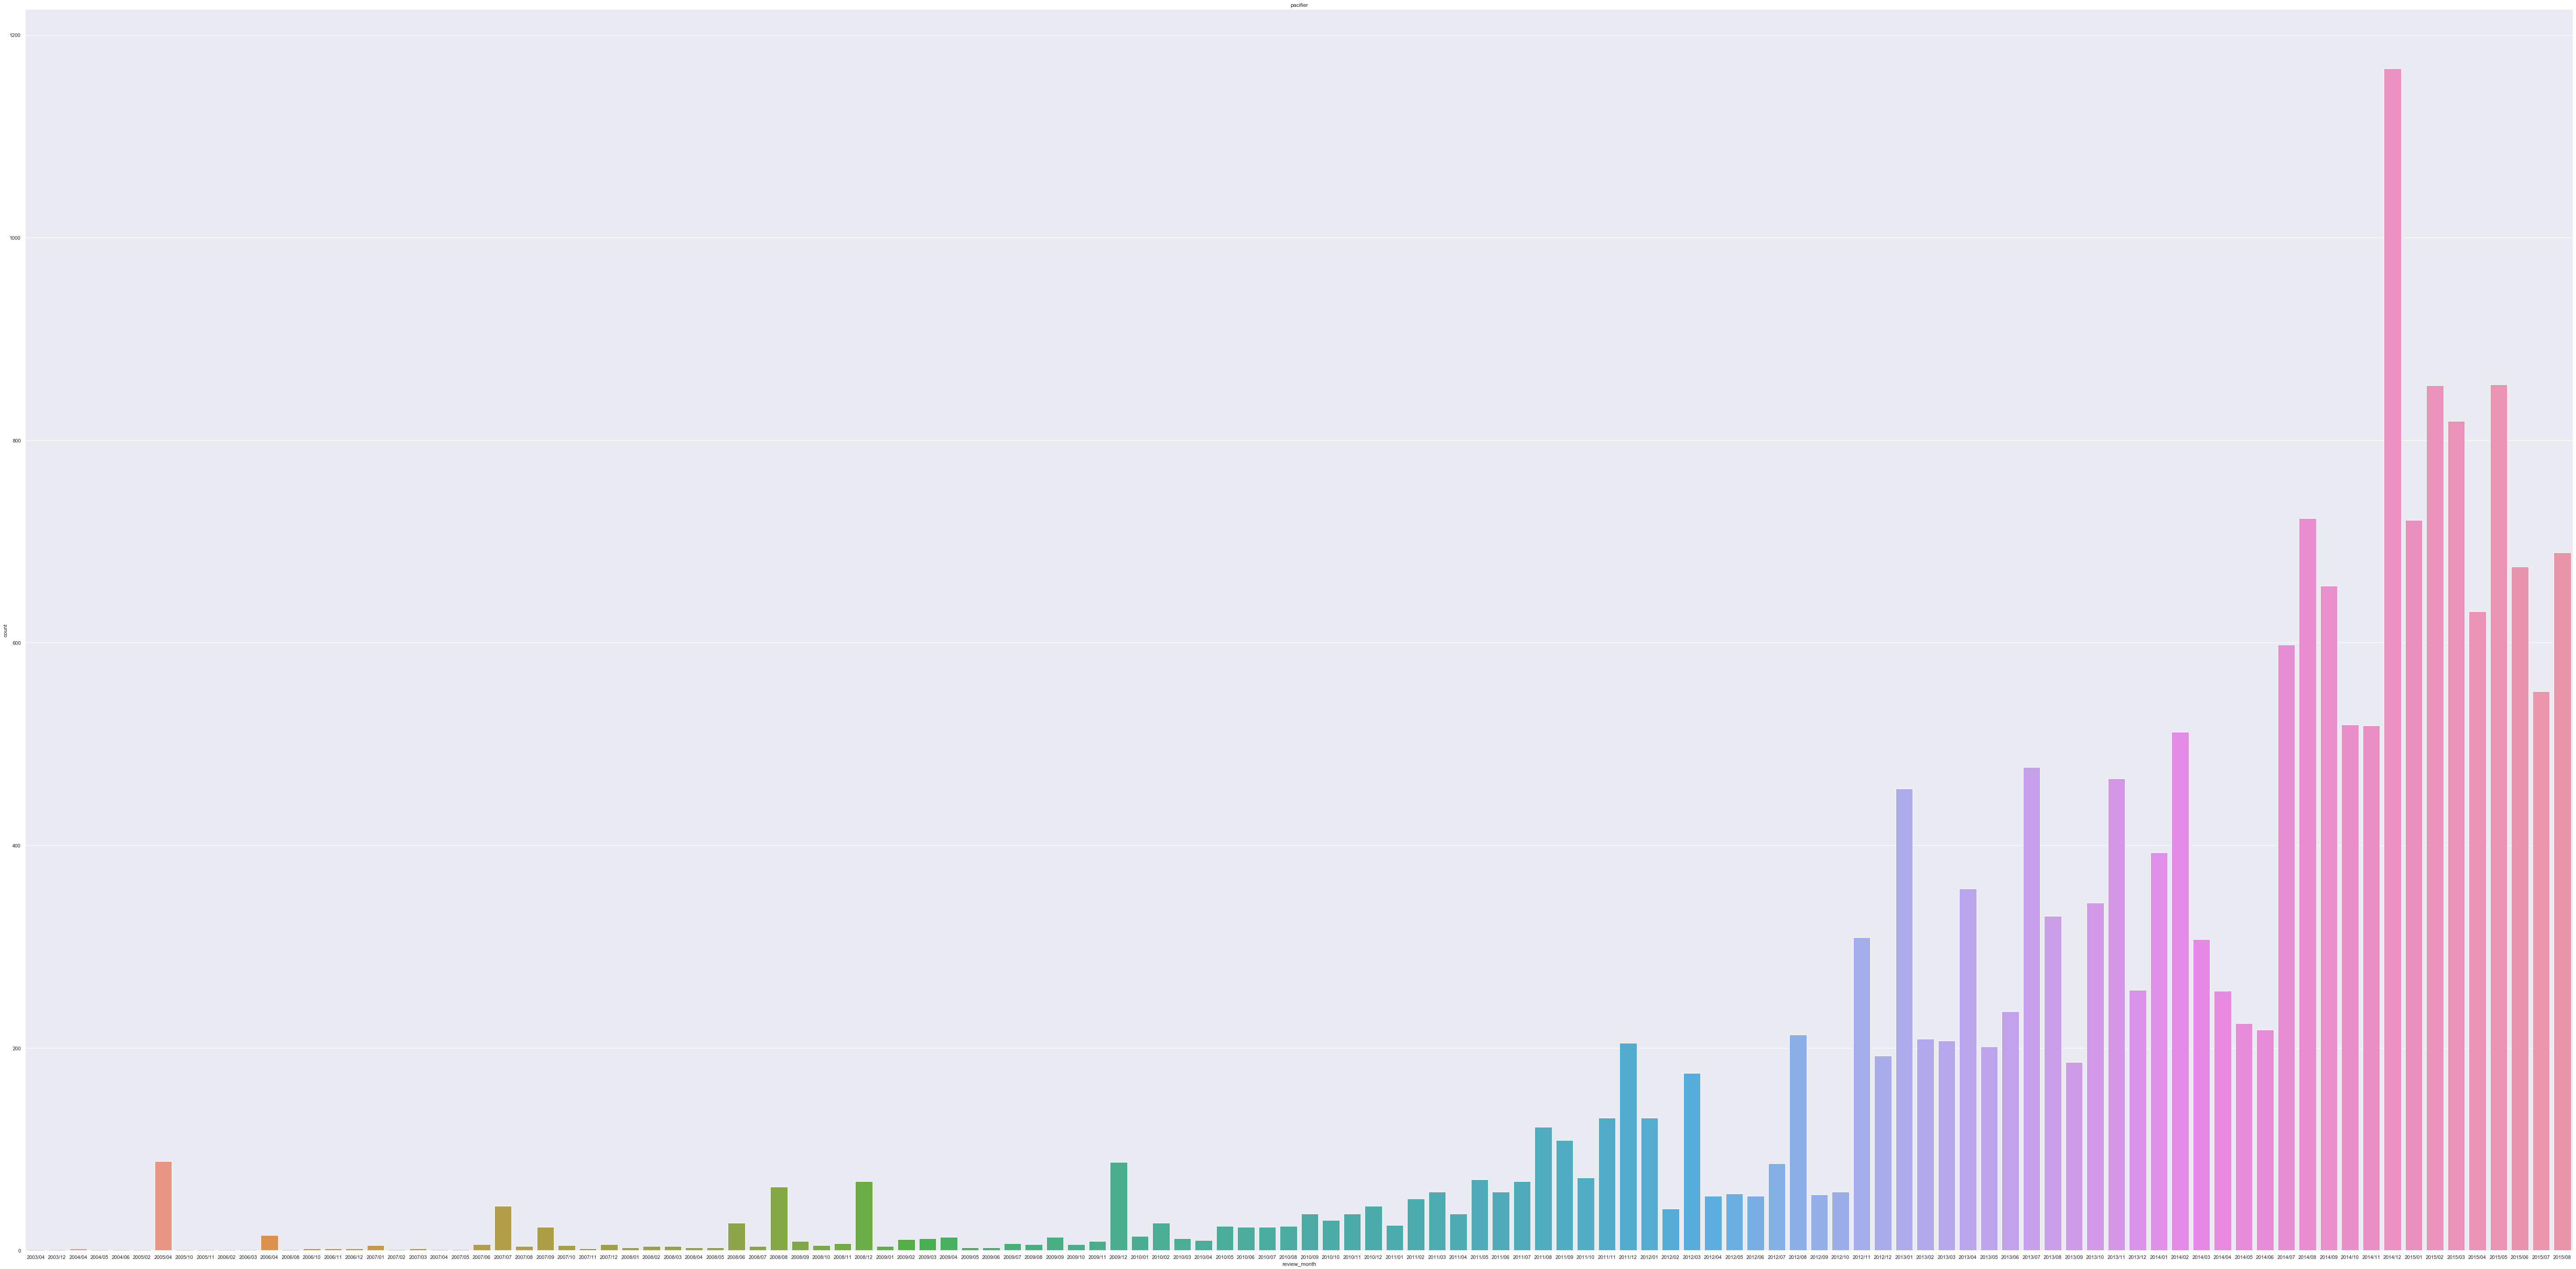

In [67]:
#按月份排列
df['review_month'] = pd.to_datetime(df.review_date).dt.strftime("%Y/%m")
df.sort_values("review_month",inplace=True)
# 销量
plt.figure(figsize=(100,50))
plt.title("pacifier")
sns.countplot(x="review_month", data=df)

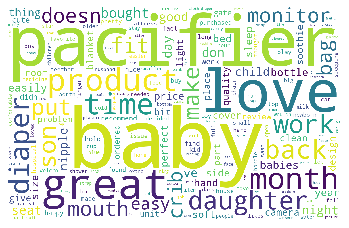

In [68]:
# 2011/11 - 2012/1, 2012/12 - 2013/2, 2014/6-2014/8
# 帮助没用的
txt = getTxt(df.loc[df['review_month'] == '2011/11', 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file("unhelpful.png") # 保存
# 打印前20个词
unhelpful_word = countWord(txt)
unhelpful_title = df.loc[df['helpful_votes'] == 0, 'product_title'].value_counts()[:10]


In [69]:
pd.DataFrame(unhelpful_word)

,0,1
0,baby,69
1,great,49
2,product,43
3,love,40
4,pacifier,39
5,time,35
6,back,30
7,daughter,30
8,son,29
9,months,28


<BarContainer object of 120 artists>

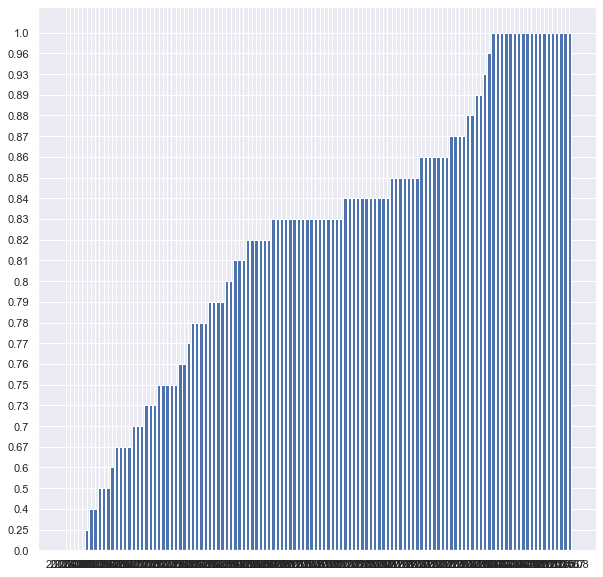

In [42]:

reputation_list = []
for month in set(df['review_month'].values):
    positive_number = np.sum(df.loc[df['review_month'] == month, 'satisfied_score'] > 0)
    rate = positive_number / sum(
        df['review_month'] == month)
    rate = np.round(rate, 2)
    reputation_list.append([month, rate])
reputation_list = np.array(reputation_list)
reputation_list.sort(axis = 0) # 将年份排列

plt.figure(figsize=(10 ,10))
plt.bar(reputation_list[:,0], reputation_list[:,1])
# 可以看到声誉一直在增长

### c)以寻找一个“暗示或预示产品的成功或失败的”**潜在性**的方法为目的，确定一套“基于文本(text-based)和评级(rating-based)的综合度量方法”；
	产品成败的潜在性的度量主要是看销量的增减趋势
    确定文本(text-based)和评级(rating-based)之间的最佳权重,来预测产品是否会成功.初步的想法是用这两个指标,通过决策树模型拟合,计算重要程度,把重要程度作为权重.产品成败的潜在性就看销量增加还是减少.

In [ ]:

# 帮助没用的
txt = getTxt(df.loc[df['review_month'] == '2012/07', 'review'].values)
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(txt)
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file("unhelpful.png") # 保存
# 打印前20个词
unhelpful_word = countWord(txt)
unhelpful_title = df.loc[df['helpful_votes'] == 0, 'product_title'].value_counts()[:10]


In [43]:
# 分析两者关联性
df[['mentioned_rate', 'helpful_votes', 'review_sentiment']].corr()

,mentioned_rate,helpful_votes,review_sentiment
mentioned_rate,1.000000,0.228382,0.205035
helpful_votes,0.228382,1.000000,-0.039492
review_sentiment,0.205035,-0.039492,1.000000


In [44]:
# 分析两者关联性
df[['star_sentiment', 'review_sentiment']].corr()

,star_sentiment,review_sentiment
star_sentiment,1.000000,0.394781
review_sentiment,0.394781,1.000000


### d)特定的星级是否会引起更多的评论？例如，客户看到一连串的差评，他是否会更倾向于写一个差评呢？
根据时间段, 分析星级对接下来的评论的影响.查看有连续差评的时间段中的评论分成一些小问题


In [45]:
#随机选取了一些情感强烈的词

# 连续好评




In [46]:
#连续差评

### e)特定质量的文本评论(text-based reviews)是否和评级(rating)有强关联性呢？例如，“对产品很满意！”，“对产品很失望！”
	特定文本是否与评级有很强的关联.看给出高评分的的用户的评论中的高频词汇.

In [80]:
positive_words = ['great', 'love', 'perfect', 'nice', 'awesome', 'excellent','excellent','excited']
negative_words = ['worst', 'disappointed', 'annoying', 'junk', 'sucks', 'frustating']

def is_positive(ss):
    for word in ss.split():
        if word in positive_words:
            return 1
    return 0

def is_negative(ss):
    for word in ss.split():
        if word in negative_words:
            return 1
    return 0

df['is_positive'] = df.review.apply(is_positive)
df['is_negative'] = df.review.apply(is_negative)

In [91]:
df[['star_rating', 'is_positive']].corr()

,star_rating,is_positive
star_rating,1.000000,0.270844
is_positive,0.270844,1.000000


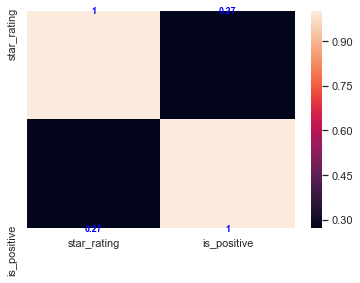

In [90]:
sns.heatmap(df[['star_rating', 'is_positive']].corr(), annot=True, annot_kws={'size':9,'weight':'bold', 'color':'blue'})

In [92]:
df[['star_rating', 'is_negative']].corr()

,star_rating,is_negative
star_rating,1.000000,-0.223383
is_negative,-0.223383,1.000000


(0.0, 2.0, 1.5, 0.5)

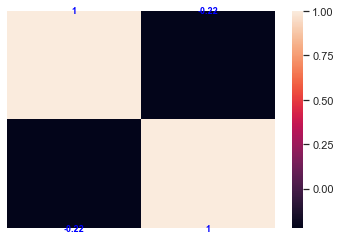

In [89]:
sns.heatmap(df[['star_rating', 'is_negative']].corr(), annot=True, annot_kws={'size':9,'weight':'bold', 'color':'blue'})

In [47]:
review_negative_word

[('baby', 625),
 ('pacifier', 502),
 ('pacifiers', 356),
 ('son', 251),
 ('time', 238),
 ('product', 237),
 ('daughter', 234),
 ('hard', 231),
 ('mouth', 223),
 ('don', 212),
 ('loves', 196),
 ('months', 194),
 ('bought', 188),
 ('back', 163),
 ('small', 162),
 ('doesn', 162),
 ('didn', 162),
 ('nipple', 154),
 ('put', 149),
 ('disappointed', 148)]

In [48]:
all_word # great,love，perfect，nice，awesome

[('baby', 7137),
 ('pacifier', 5096),
 ('great', 4370),
 ('love', 3646),
 ('pacifiers', 3198),
 ('loves', 2985),
 ('son', 2758),
 ('easy', 2610),
 ('product', 2601),
 ('daughter', 2536),
 ('good', 2029),
 ('bought', 1974),
 ('mouth', 1907),
 ('time', 1893),
 ('cute', 1827),
 ('months', 1784),
 ('don', 1623),
 ('put', 1510),
 ('find', 1447),
 ('doesn', 1418),
 ('seat', 1397),
 ('back', 1363),
 ('perfect', 1222),
 ('month', 1211),
 ('bag', 1184),
 ('quality', 1182),
 ('nice', 1161),
 ('hold', 1147),
 ('didn', 1109),
 ('paci', 1106),
 ('buy', 1097),
 ('made', 1070),
 ('size', 1033),
 ('clean', 1018),
 ('car', 1015),
 ('babies', 1008),
 ('soft', 985),
 ('work', 973),
 ('gift', 973),
 ('night', 967),
 ('loved', 954),
 ('thing', 952),
 ('small', 927),
 ('works', 915),
 ('price', 915),
 ('ve', 912),
 ('recommend', 911),
 ('nipple', 909),
 ('child', 906),
 ('fit', 890)]

In [ ]:
worst，Disappointed

In [49]:
# 星级和评论的相关系数
df[['review_sentiment', 'star_rating']].corr()

,review_sentiment,star_rating
review_sentiment,1.00000,0.39352
star_rating,0.39352,1.00000


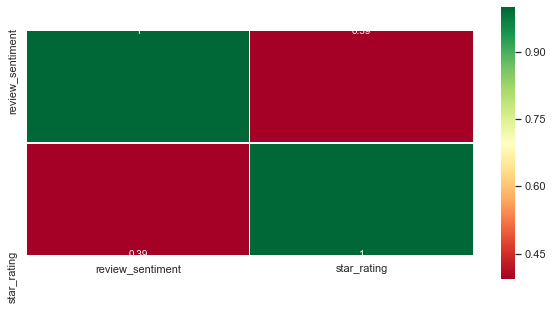

In [50]:
# 星级和评论的相关系数, 可视化看看
plt.figure(figsize=(10, 5))
sns.heatmap(df[['review_sentiment', 'star_rating']].corr(),linewidths=0.1,vmax=1.0,square=True, cmap='RdYlGn', linecolor='white',annot=True)
plt.show()

## 顾客id

In [51]:
# 这个人买了4次， 购买次数最多的之一。还每次都给了差评。。。这是多大的仇恨。。。
df[df.customer_id == 2567729]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,review_body,review_date,review,star_sentiment,review_sentiment,satisfied_score,mentioned_rate,review_len,review_year,review_month


In [52]:
def get_bought_times(id):
    global df
    return len(df[df.customer_id == id])

In [53]:
# 每个顾客的购买次数
df['bought_times'] = df.customer_id.apply(get_bought_times)

In [54]:
df['bought_times'].value_counts()

1     16601
2      1804
3       375
4        84
5        30
7        14
6        12
10       10
9         9
Name: bought_times, dtype: int64

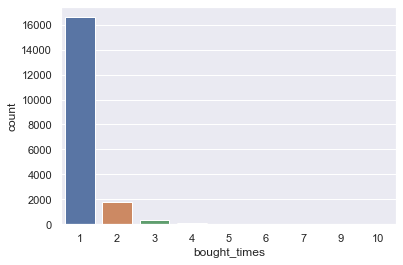

In [55]:
sns.countplot(x="bought_times", data = df)

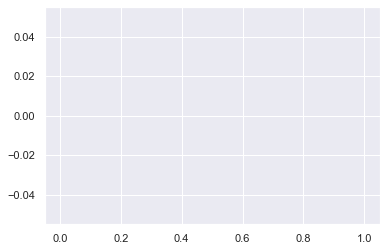

In [56]:
df.helpful_votes[df.helpful_votes > 100].hist() # 帮助点赞数大于100的分布，

In [57]:
df[['vine', 'helpful_votes']].corr() # 奇怪， 竟然相关性不高

,helpful_votes
helpful_votes,1.0


In [58]:
# 分析下是不是vine 对帮助等级影响大
df.loc[df['vine'] == 'Y', 'vine'] = 1
df.loc[df['vine'] == 'N', 'vine'] = 0

In [59]:
def getTxt(ss):
    '''ss是包含字符串的数组，返回一个字符串'''
    txt = ""
    for i in range(len(ss)):
        txt += ss[i]
    return txt

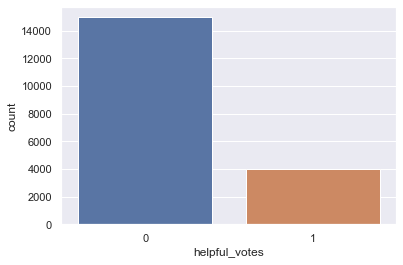

In [60]:
sns.countplot(x="helpful_votes", data = df)

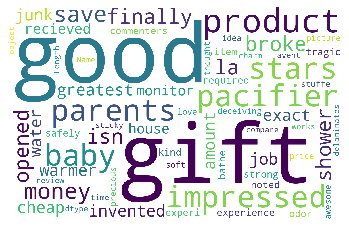

In [61]:
# 星级高的
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(str(df.loc[df['helpful_votes'] == 1, 'review']))
plt.imshow(wordcloud)
plt.axis("off")

wordcloud.to_file("hairdryer_helpful.png")

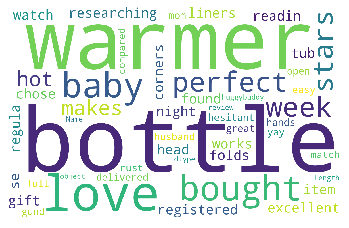

In [62]:
# 星级高的
wordcloud = WordCloud(
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10               #设置图片的边缘
        ).generate(str(df.loc[df['helpful_votes'] == 0, 'review']))
plt.imshow(wordcloud)
plt.axis("off")

wordcloud.to_file("hairdryer_unhelpful.png")

In [63]:
# 星级和评论的相关系数
df[['review_sentiment', 'star_rating', 'helpful_votes']].corr()

,review_sentiment,star_rating,helpful_votes
review_sentiment,1.000000,0.39352,-0.039492
star_rating,0.393520,1.00000,-0.198840
helpful_votes,-0.039492,-0.19884,1.000000


In [64]:
df.loc[df['verified_purchase'] == 'Y', 'verified_purchase'] = 1
df.loc[df['verified_purchase'] == 'N', 'verified_purchase'] = 0

In [65]:
df[['review_sentiment', 'star_rating', 'helpful_votes', 'verified_purchase']].corr()

,review_sentiment,star_rating,helpful_votes
review_sentiment,1.000000,0.39352,-0.039492
star_rating,0.393520,1.00000,-0.198840
helpful_votes,-0.039492,-0.19884,1.000000


In [66]:
df.verified_purchase.value_counts()

1    9791
y    6470
0    1407
n    1271
Name: verified_purchase, dtype: int64